### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pytrends.request import TrendReq

## Retail Ecommerce Sales data

In [2]:
data = pd.read_csv('../../data/retailEcommercesales/retailEcommerceSales.csv',sep=',')

In [3]:
retailEcommercesales = data[~data["Sales"].str.contains('unadjusted')]

In [4]:
retailEcommercesales = retailEcommercesales.filter(['REF_DATE','VALUE'])
retailEcommercesales.columns = retailEcommercesales.columns.str.replace('VALUE', 'Ecommerce_sales')
retailEcommercesales.columns = retailEcommercesales.columns.str.replace('REF_DATE', 'Date')

In [5]:
retailEcommercesales.dtypes

Date               object
Ecommerce_sales     int64
dtype: object

In [6]:
retailEcommercesales.head(2)

,Date,Ecommerce_sales
3,2016-01,977198
7,2016-02,1006610


In [28]:
retailEcommercesales.shape

(74, 2)

## Time series plot of Retail Ecommerce Sales

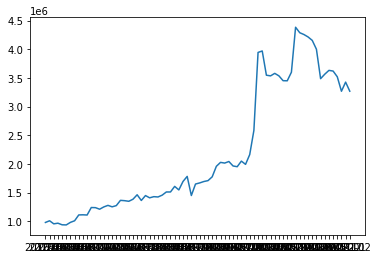

In [7]:
retailEcommercesales_dup = retailEcommercesales.copy()
retailEcommercesales_dup.index=retailEcommercesales_dup['Date']
plt.plot(retailEcommercesales_dup['Ecommerce_sales'])
plt.show()

In [23]:
pytrends = TrendReq(hl='en-us', backoff_factor=0.1)

In [24]:
kw_list = ["Blockchain","recession","inflation"]
pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='CA', gprop='')

In [ ]:
pytrends.interest_over_time()

In [44]:
def ecommerce_trend(keywords=[''],category='0'):
    kw_list = keyword
    cat=category
    timeframe = '2004-01-01 2022-05-09'
    geo='CA'
    
    pytrends.build_payload(kw_list, cat, timeframe, geo, gprop='')
    data=pytrends.interest_over_time()
    return data
    
    

In [40]:
keyword=["ecommerce"]
category='520'
data = ecommerce_trend()

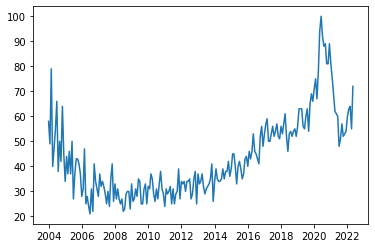

In [41]:
trend_data = data.copy()
plt.plot(trend_data[keyword])
plt.show()

In [46]:
data=ecommerce_trend(keywords=[''],category='520')

In [47]:
data

,ecommerce,isPartial
date,,
2004-01-01,0,False
2004-02-01,0,False
2004-03-01,0,False
2004-04-01,0,False
2004-05-01,0,False
...,...,...
2022-01-01,24,False
2022-02-01,27,False
2022-03-01,0,False
